In [ ]:
import logging

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(
    filename='model_experiments.log',
    level=logging.INFO,
    format='%(message)s',
    force=True
)

def log_experiment(model_name, params, accuracy, notes=""):
    entry = (
        f"\nMODEL: {model_name}\n"
        f"PARAMS: {params}\n"
        f"ACCURACY: {accuracy:.4f}\n"
        f"NOTES: {notes}\n"
        + "-"*30
    )
    logging.info(entry)
    print("Experiment saved (no date).")

**Data** **Preprocessing**

In [1]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 4.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import re
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [5]:
df = pd.read_csv('corrected_datasetfinalized.csv')

In [6]:
stop_words = set(stopwords.words('english')) - {'no', 'not', 'never'}
lemmatizer = WordNetLemmatizer()
negation_words = {'not', 'no', 'never'}


In [7]:
def preprocess_text_mnb(text):

    text = contractions.fix(text)

    text = text.lower()

    text = text.replace('_', ' ')

    text = re.sub(r"[^a-zA-Z0-9!?.,]+", " ", text)

    text = re.sub(r"\s+", " ", text).strip()

    # Tokenize
    words = text.split()

    processed_words = []
    negation = False

    for word in words:
        if word in negation_words:
            negation = True
            processed_words.append(word)
            continue

        if word in {'.', '!', '?'}:
            negation = False
            processed_words.append(word)
            continue

        if word in stop_words:
            continue

        lemma = lemmatizer.lemmatize(word)

        if negation:
            lemma = lemma + "_NEG"

        processed_words.append(lemma)

    return " ".join(processed_words)


In [8]:
df['preprocessed_text_mnb'] = df['clean_text'].apply(preprocess_text_mnb)
df[['clean_text','preprocessed_text_mnb']].head(10)

,clean_text,preprocessed_text_mnb
0,and i can't get rid of this picture either,cannot get rid picture either
1,why are you so sick in the head why can't you ...,sick head cannot normal not crazy_NEG
2,i wish i could see her at her first day at school,wish could see first day school
3,how no matter how much i'd like to not hate yo...,no matter_NEG much_NEG would_NEG like_NEG not ...
4,i'll miss you,miss
5,i don't understand how you can be so mean,not understand_NEG mean_NEG
6,and my mama weighs 312 pounds,mama weighs 312 pound
7,so you knew and you looked me in my face,knew looked face
8,how can you live with yourself,live
9,but for my part i love him not,part love not


In [9]:
df.to_csv('preprocessed_dataset_mnb.csv', index=False)

In [10]:
df_mnb = df[['preprocessed_text_mnb', 'emotion_id', 'trigger_id']].copy()

In [11]:
df_mnb = df_mnb[df_mnb['preprocessed_text_mnb'].str.strip() != ""]

In [12]:
df_mnb['preprocessed_text_mnb'] = df_mnb['preprocessed_text_mnb'].str.replace(r'\s+', ' ', regex=True)

In [ ]:
df_mnb = df_mnb.reset_index(drop=True)


In [13]:
print(df_mnb.head(10))

                               preprocessed_text_mnb  emotion_id  trigger_id
0                      cannot get rid picture either           1           2
1              sick head cannot normal not crazy_NEG           0           0
2                    wish could see first day school           1           2
3  no matter_NEG much_NEG would_NEG like_NEG not ...           0           0
4                                               miss           1           2
5                        not understand_NEG mean_NEG           0           0
6                              mama weighs 312 pound           1           2
7                                   knew looked face           0           0
8                                               live           1           0
9                                      part love not           0           0


**shuffling & TF-IDF Feature Extraction**

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [177]:
X_raw = df_mnb['preprocessed_text_mnb']
y_emotion = df_mnb['emotion_id']
y_trigger = df_mnb['trigger_id']


In [178]:
X_train_raw_emotion, X_test_raw_emotion, y_train_emotion, y_test_emotion = train_test_split(
    X_raw, y_emotion, test_size=0.2, random_state=42, stratify=y_emotion
)

X_train_raw_trigger, X_test_raw_trigger, y_train_trigger, y_test_trigger = train_test_split(
    X_raw, y_trigger, test_size=0.2, random_state=42, stratify=y_trigger
)


In [179]:
tfidf_vectorizer_emotion = TfidfVectorizer(ngram_range=(1,2), lowercase=True)
X_train_tfidf_emotion = tfidf_vectorizer_emotion.fit_transform(X_train_raw_emotion)
X_test_tfidf_emotion = tfidf_vectorizer_emotion.transform(X_test_raw_emotion)

tfidf_vectorizer_trigger = TfidfVectorizer(ngram_range=(1,2), lowercase=True)
X_train_tfidf_trigger = tfidf_vectorizer_trigger.fit_transform(X_train_raw_trigger)
X_test_tfidf_trigger = tfidf_vectorizer_trigger.transform(X_test_raw_trigger)


In [182]:
print("Emotion - X_train:", X_train_tfidf_emotion.shape, "X_test:", X_test_tfidf_emotion.shape)

Emotion - X_train: (69, 452) X_test: (18, 452)


In [183]:
print("Trigger - X_train:", X_train_tfidf_trigger.shape, "X_test:", X_test_tfidf_trigger.shape)

Trigger - X_train: (69, 470) X_test: (18, 470)


In [196]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
mnb_emotion = MultinomialNB(alpha=5, fit_prior=True)


In [197]:
mnb_emotion.fit(X_train_tfidf_emotion, y_train_emotion)

MultinomialNB(alpha=5)

In [198]:
y_pred_emotion = mnb_emotion.predict(X_test_tfidf_emotion)

In [199]:
print("Emotion Prediction Accuracy:", accuracy_score(y_test_emotion, y_pred_emotion))
print("Emotion Classification Report:\n", classification_report(y_test_emotion, y_pred_emotion))
print("Emotion Confusion Matrix:\n", confusion_matrix(y_test_emotion, y_pred_emotion))

Emotion Prediction Accuracy: 0.16666666666666666
Emotion Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         5
           2       0.33      0.25      0.29         4
           3       0.15      0.40      0.22         5

    accuracy                           0.17        18
   macro avg       0.12      0.16      0.13        18
weighted avg       0.12      0.17      0.13        18

Emotion Confusion Matrix:
 [[0 0 0 4]
 [0 0 0 5]
 [0 1 1 2]
 [0 1 2 2]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [200]:
y_train_pred_emotion = mnb_emotion.predict(X_train_tfidf_emotion)

print("Train Accuracy:", accuracy_score(y_train_emotion, y_train_pred_emotion))
print("Train Classification Report:\n", classification_report(y_train_emotion, y_train_pred_emotion))
print("Train Confusion Matrix:\n", confusion_matrix(y_train_emotion, y_train_pred_emotion))


Train Accuracy: 0.7971014492753623
Train Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.90      1.00      0.95        18
           2       1.00      1.00      1.00        18
           3       0.61      1.00      0.76        19

    accuracy                           0.80        69
   macro avg       0.63      0.75      0.68        69
weighted avg       0.66      0.80      0.72        69

Train Confusion Matrix:
 [[ 0  2  0 12]
 [ 0 18  0  0]
 [ 0  0 18  0]
 [ 0  0  0 19]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [211]:
mnb_trigger = MultinomialNB(alpha=2, fit_prior=True)
mnb_trigger.fit(X_train_tfidf_trigger, y_train_trigger)

MultinomialNB(alpha=2)

In [212]:
y_pred_trigger = mnb_trigger.predict(X_test_tfidf_trigger)


In [213]:
print("Trigger Prediction Accuracy:", accuracy_score(y_test_trigger, y_pred_trigger))
print("Trigger Classification Report:\n", classification_report(y_test_trigger, y_pred_trigger))
print("Trigger Confusion Matrix:\n", confusion_matrix(y_test_trigger, y_pred_trigger))

Trigger Prediction Accuracy: 0.16666666666666666
Trigger Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         3
           4       0.18      0.75      0.29         4
           5       0.00      0.00      0.00         3

    accuracy                           0.17        18
   macro avg       0.03      0.12      0.05        18
weighted avg       0.04      0.17      0.06        18

Trigger Confusion Matrix:
 [[0 0 0 0 3 0]
 [0 0 0 0 3 0]
 [0 0 0 0 2 0]
 [0 0 0 0 3 0]
 [0 0 0 0 3 1]
 [0 0 0 0 3 0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [214]:
y_train_pred_trigger = mnb_trigger.predict(X_train_tfidf_trigger)

print("Train Accuracy:", accuracy_score(y_train_trigger, y_train_pred_trigger))
print("Train Classification Report:\n", classification_report(y_train_trigger, y_train_pred_trigger))
print("Train Confusion Matrix:\n", confusion_matrix(y_train_trigger, y_train_pred_trigger))


Train Accuracy: 0.7246376811594203
Train Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.82      0.90        11
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00         8
           3       1.00      1.00      1.00        12
           4       0.47      1.00      0.64        17
           5       1.00      1.00      1.00        12

    accuracy                           0.72        69
   macro avg       0.58      0.64      0.59        69
weighted avg       0.62      0.72      0.65        69

Train Confusion Matrix:
 [[ 9  0  0  0  2  0]
 [ 0  0  0  0  9  0]
 [ 0  0  0  0  8  0]
 [ 0  0  0 12  0  0]
 [ 0  0  0  0 17  0]
 [ 0  0  0  0  0 12]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**oversampling for MNB**

In [148]:
from sklearn.utils import resample

max_size = df_mnb['trigger_id'].value_counts().max()

lst = [df_mnb]
for trigger_id, group in df_mnb.groupby('trigger_id'):
    lst.append(resample(group,
                        replace=True,
                        n_samples=max_size,
                        random_state=42))

df_trigger_balanced = pd.concat(lst)

df_trigger_balanced = df_trigger_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_trigger_balanced['trigger_id'].value_counts())

trigger_id
4    42
5    36
3    36
0    35
1    33
2    31
Name: count, dtype: int64


In [149]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,2))
X_balanced = vectorizer.fit_transform(df_trigger_balanced['preprocessed_text_mnb'])
y_balanced = df_trigger_balanced['trigger_id']


In [150]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)


In [161]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

mnb_trigger = MultinomialNB()
mnb_trigger.fit(X_train, y_train)

y_pred = mnb_trigger.predict(X_test)

In [162]:
print("Trigger prediction accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Trigger prediction accuracy: 0.8837209302325582
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       1.00      1.00      1.00         7
           2       0.75      1.00      0.86         6
           3       1.00      1.00      1.00         7
           4       0.78      0.78      0.78         9
           5       0.86      0.86      0.86         7

    accuracy                           0.88        43
   macro avg       0.90      0.89      0.89        43
weighted avg       0.90      0.88      0.88        43

Confusion Matrix:
 [[5 0 0 0 1 1]
 [0 7 0 0 0 0]
 [0 0 6 0 0 0]
 [0 0 0 7 0 0]
 [0 0 2 0 7 0]
 [0 0 0 0 1 6]]


In [163]:
from sklearn.metrics import accuracy_score, classification_report

y_train_pred = mnb_trigger.predict(X_train_trigger)
print("Train Accuracy:", accuracy_score(y_train_trigger, y_train_pred))
print("Train Classification Report:\n", classification_report(y_train_trigger, y_train_pred))

y_test_pred = mnb_trigger.predict(X_test_trigger)
print("Test Accuracy:", accuracy_score(y_test_trigger, y_test_pred))
print("Test Classification Report:\n", classification_report(y_test_trigger, y_test_pred))


Train Accuracy: 0.9420289855072463
Train Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.82      0.90        11
           1       1.00      1.00      1.00         9
           2       0.89      1.00      0.94         8
           3       1.00      1.00      1.00        12
           4       0.89      0.94      0.91        17
           5       0.92      0.92      0.92        12

    accuracy                           0.94        69
   macro avg       0.95      0.95      0.95        69
weighted avg       0.95      0.94      0.94        69

Test Accuracy: 0.9444444444444444
Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       0.67      1.00      0.80         2
           3       1.00      1.00      1.00         3
           4       1.00      0.75      0.86         4
    

**over sampling on emotion**

In [164]:
from sklearn.utils import resample

max_size = df_mnb['emotion_id'].value_counts().max()

lst = [df_mnb]
for emotion_id, group in df_mnb.groupby('emotion_id'):
    lst.append(resample(group,
                        replace=True,
                        n_samples=max_size,
                        random_state=42))

df_emotion_balanced = pd.concat(lst)

df_emotion_balanced = df_emotion_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_emotion_balanced['emotion_id'].value_counts())


emotion_id
3    48
1    47
2    46
0    42
Name: count, dtype: int64


In [165]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,2))
X_balanced = vectorizer.fit_transform(df_emotion_balanced['preprocessed_text_mnb'])
y_balanced = df_emotion_balanced['emotion_id']

print("TF-IDF feature matrix shape:", X_balanced.shape)


TF-IDF feature matrix shape: (183, 556)


In [166]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (146, 556) Test shape: (37, 556)


In [175]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

mnb = MultinomialNB(alpha=2, fit_prior=True)
mnb.fit(X_train, y_train)

y_pred = mnb.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Test Accuracy: 0.918918918918919
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00         9
           3       0.77      1.00      0.87        10

    accuracy                           0.92        37
   macro avg       0.94      0.91      0.91        37
weighted avg       0.94      0.92      0.91        37

Confusion Matrix:
 [[ 5  0  0  3]
 [ 0 10  0  0]
 [ 0  0  9  0]
 [ 0  0  0 10]]


In [176]:
from sklearn.metrics import accuracy_score, classification_report

y_train_pred = mnb.predict(X_balanced)
print("Train Accuracy:", accuracy_score(y_balanced, y_train_pred))
print("Train Classification Report:\n", classification_report(y_balanced, y_train_pred))


Train Accuracy: 0.9836065573770492
Train Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.93      0.96        42
           1       1.00      1.00      1.00        47
           2       1.00      1.00      1.00        46
           3       0.94      1.00      0.97        48

    accuracy                           0.98       183
   macro avg       0.99      0.98      0.98       183
weighted avg       0.98      0.98      0.98       183



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


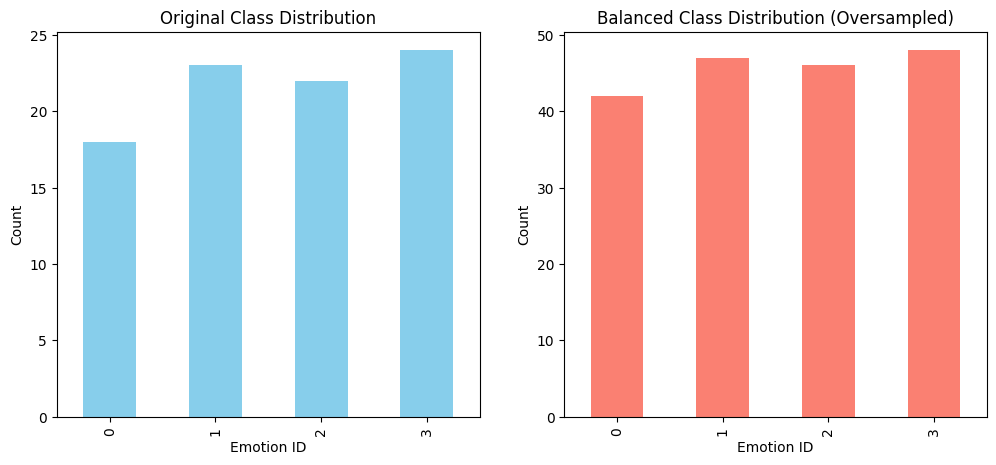

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
df_mnb['emotion_id'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Original Class Distribution')
plt.xlabel('Emotion ID')
plt.ylabel('Count')

plt.subplot(1,2,2)
df_emotion_balanced['emotion_id'].value_counts().sort_index().plot(kind='bar', color='salmon')
plt.title('Balanced Class Distribution (Oversampled)')
plt.xlabel('Emotion ID')
plt.ylabel('Count')

plt.show()

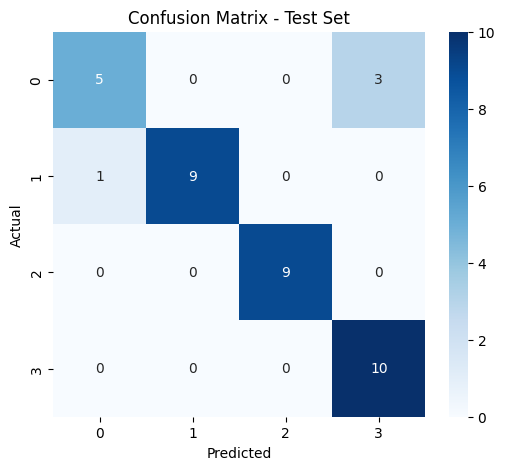

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()